### Imports

In [23]:
import os
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import skimage.io

In [3]:
import tensorflow as tf

from chestxray.config import (PANDA_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
CLASS_COLUMN = 'isup_grade'
IMAGE_COLUMN = 'image_id'
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 16


### Retrieve the Images

In [6]:
ls -la {PANDA_PATH}/

total 2020
drwxrwxr-x 4 ademyanchuk ademyanchuk   4096 Apr 29 07:21 ./
drwxr-xr-x 8 ademyanchuk ademyanchuk   4096 Apr 28 13:53 ../
-rw-rw-r-- 1 ademyanchuk ademyanchuk    125 Apr 22 02:10 sample_submission.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk    149 Apr 22 02:10 test.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk 520203 Apr 22 02:10 train.csv
drwxrwxr-x 2 ademyanchuk ademyanchuk 724992 Apr 28 23:31 train_images/
drwxrwxr-x 2 ademyanchuk ademyanchuk 802816 Apr 28 23:33 train_label_masks/


In [7]:
PANDA_IMGS

PosixPath('/home/ademyanchuk/Projects/ChestXRay/data/Panda/train_images')

In [8]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)

In [9]:
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [10]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


In [11]:
image_count = len(list(PANDA_IMGS.glob('*.tiff')))

In [12]:
assert len(TRAIN_DF) == len(set(TRAIN_DF[IMAGE_COLUMN])) == image_count

In [19]:
def img_path_from_id(image_id, suffix=".tiff"):
    return PANDA_IMGS / (image_id + suffix)

def mask_path_from_id(image_id, suffix="_mask.tiff"):
    return PANDA_PATH / ("train_label_masks/" + image_id + suffix)

def cls_label_from_id(image_id):
    try:
        return TRAIN_DF.loc[TRAIN_DF[IMAGE_COLUMN] == image_id,
                            CLASS_COLUMN].values[0]
    except IndexError:
        raise

Radboud: Prostate glands are individually labelled. Valid values are:
- 0: background (non tissue) or unknown
- 1: stroma (connective tissue, non-epithelium tissue)
- 2: healthy (benign) epithelium
- 3: cancerous epithelium (Gleason 3)
- 4: cancerous epithelium (Gleason 4)
- 5: cancerous epithelium (Gleason 5)

Karolinska: Regions are labelled. Valid values are:
- 1: background (non tissue) or unknown
- 2: benign tissue (stroma and epithelium combined)
- 3: cancerous tissue (stroma and epithelium combined)

Biopsy dimensions: (848, 1424, 3)
Biopsy ISUP grade - 0


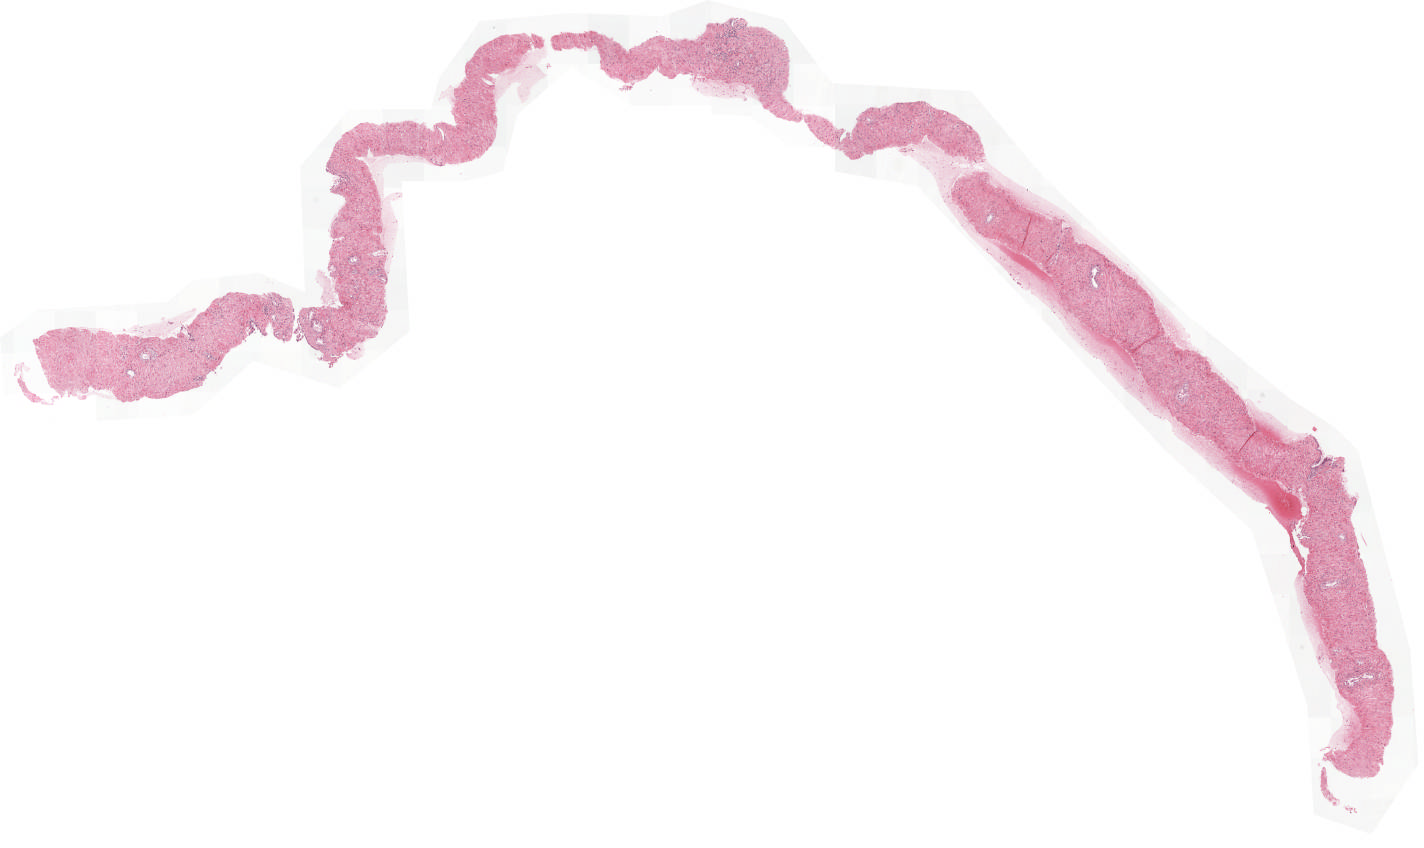

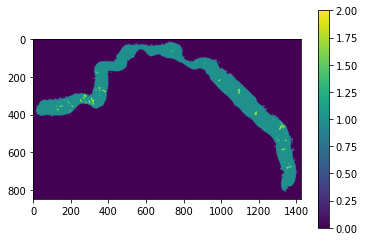

In [31]:
id_sample = TRAIN_DF[IMAGE_COLUMN].sample(1)

for image_id in id_sample:
    image_path = img_path_from_id(image_id)
    biopsy = skimage.io.MultiImage(str(image_path))
    print(f"Biopsy dimensions: {biopsy[-1].shape}")
    print(f"Biopsy ISUP grade - {cls_label_from_id(image_id)}")
    display.display(Image.fromarray(biopsy[-1]))
    mask_path = mask_path_from_id(image_id)
    if mask_path.exists():
        mask = skimage.io.MultiImage(str(mask_path))
        mask_level_2 = mask[-1][:,:,0]
        plt.figure()
        plt.imshow(mask_level_2)
        plt.colorbar()
        plt.show()
    del biopsy

### Load Using tf.data

In [70]:
fnames = np.array(TRAIN_DF[IMAGE_COLUMN].tolist())
lables = TRAIN_DF[CLASS_COLUMN].values

In [94]:
fnames = tf.convert_to_tensor(fnames)
lables = tf.convert_to_tensor(lables)

In [130]:
paths = [str(DATA_PATH/'images-small/') + fname for fname in fnames]

In [71]:
list_ds = tf.data.Dataset.list_files(str(DATA_PATH/'images-small/*'))

In [132]:
list_ds = tf.data.Dataset.from_tensor_slices(paths)

In [133]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/ademyanchuk/Projects/ChestXRay/data/images-small00008270_015.png'
b'/home/ademyanchuk/Projects/ChestXRay/data/images-small00029855_001.png'
b'/home/ademyanchuk/Projects/ChestXRay/data/images-small00001297_000.png'
b'/home/ademyanchuk/Projects/ChestXRay/data/images-small00012359_002.png'
b'/home/ademyanchuk/Projects/ChestXRay/data/images-small00017951_001.png'


In [134]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    return lables[fnames == parts[-1]]

In [135]:
get_label('/home/ademyanchuk/Projects/ChestXRay/data/images-small/00009358_001.png')

<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>

In [120]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [121]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [122]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [125]:
for image, label in labeled_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  []
Image shape:  (224, 224, 3)
Label:  []
Image shape:  (224, 224, 3)
Label:  [1]
Image shape:  (224, 224, 3)
Label:  [0]
Image shape:  (224, 224, 3)
Label:  []
Image shape:  (224, 224, 3)
Label:  [0]
Image shape:  (224, 224, 3)
Label:  [0]
Image shape:  (224, 224, 3)
Label:  [0]
Image shape:  (224, 224, 3)
Label:  [0]
Image shape:  (224, 224, 3)
Label:  []


In [110]:
ds = labeled_ds.batch(BATCH_SIZE)

In [111]:
image_batch, label_batch = next(iter(ds))

InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [0], [batch]: [1]

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [103]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [104]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

InvalidArgumentError: Cannot batch tensors with different shapes in component 1. First element had shape [1] and element 1 had shape [0].

In [101]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n]==1)
        plt.axis('off')